In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc,roc_curve,roc_auc_score

import tensorflow as tf
print("Tensorflow version:", tf.__version__)

!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling

import tensorflow.keras as keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image

!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

Tensorflow version: 2.7.0
  Cloning https://github.com/tensorflow/docs to c:\users\moon-yujin\appdata\local\temp\pip-req-build-mfv382ko
  Resolved https://github.com/tensorflow/docs to commit 4dea89e5679c0d468f16c37a12c5cd91712a5cb1


  Running command git clone -q https://github.com/tensorflow/docs 'C:\Users\Moon-yujin\AppData\Local\Temp\pip-req-build-mfv382ko'


In [2]:
df = pd.read_csv('./data/icml_face_data.csv')
df.columns = ['emotion', 'Usage', 'pixels']
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   Usage    35887 non-null  object
 2   pixels   35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [4]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [5]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
#read train data
train = pd.read_csv('./data/train.csv')
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [7]:
#read test data
test = pd.read_csv('./data/test.csv')
test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [8]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

[Text(0, 0, 'Angry'),
 Text(1, 0, 'Disgust'),
 Text(2, 0, 'Fear'),
 Text(3, 0, 'Happy'),
 Text(4, 0, 'Sad'),
 Text(5, 0, 'Surprise'),
 Text(6, 0, 'Neutral')]

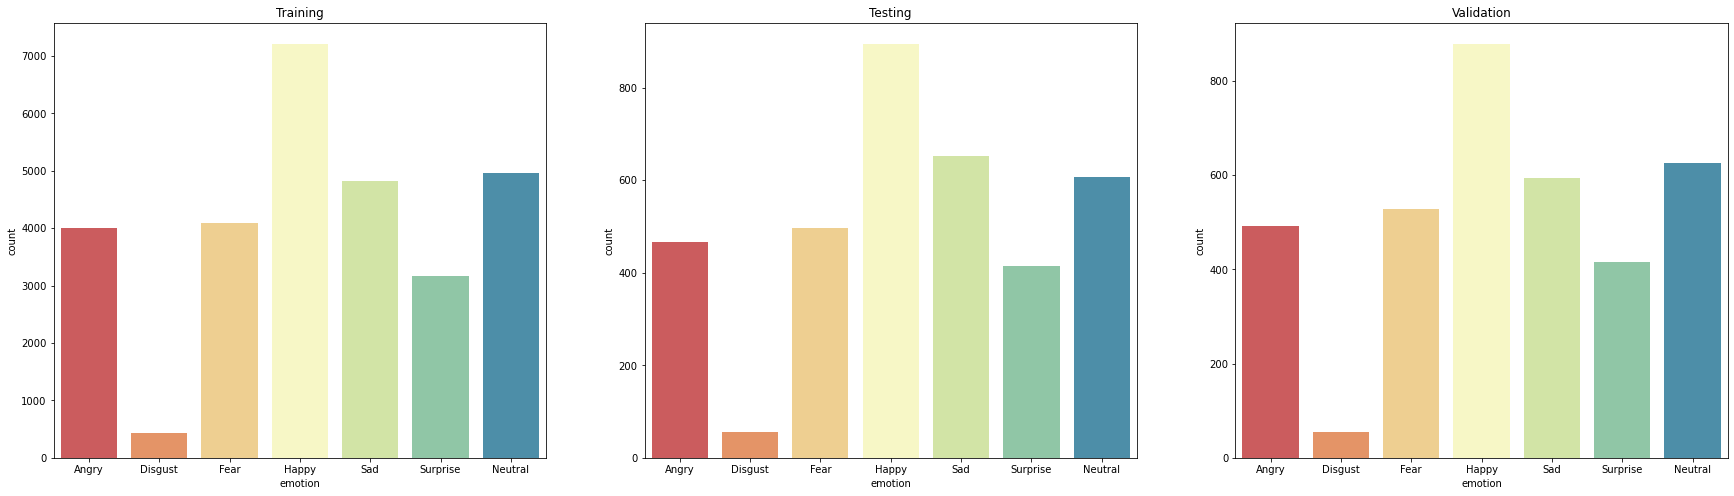

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30,8))

sns.countplot(data = df[df['Usage']=='Training'], x='emotion', ax=ax1, palette='Spectral').set_title('Training')
ax1.set_xticklabels(emotions.values())

sns.countplot(data = df[df['Usage']=='PublicTest'], x='emotion', ax=ax2, palette='Spectral').set_title('Testing')
ax2.set_xticklabels(emotions.values())

sns.countplot(data = df[df['Usage']=='PrivateTest'], x='emotion', ax=ax3, palette='Spectral').set_title('Validation')
ax3.set_xticklabels(emotions.values())

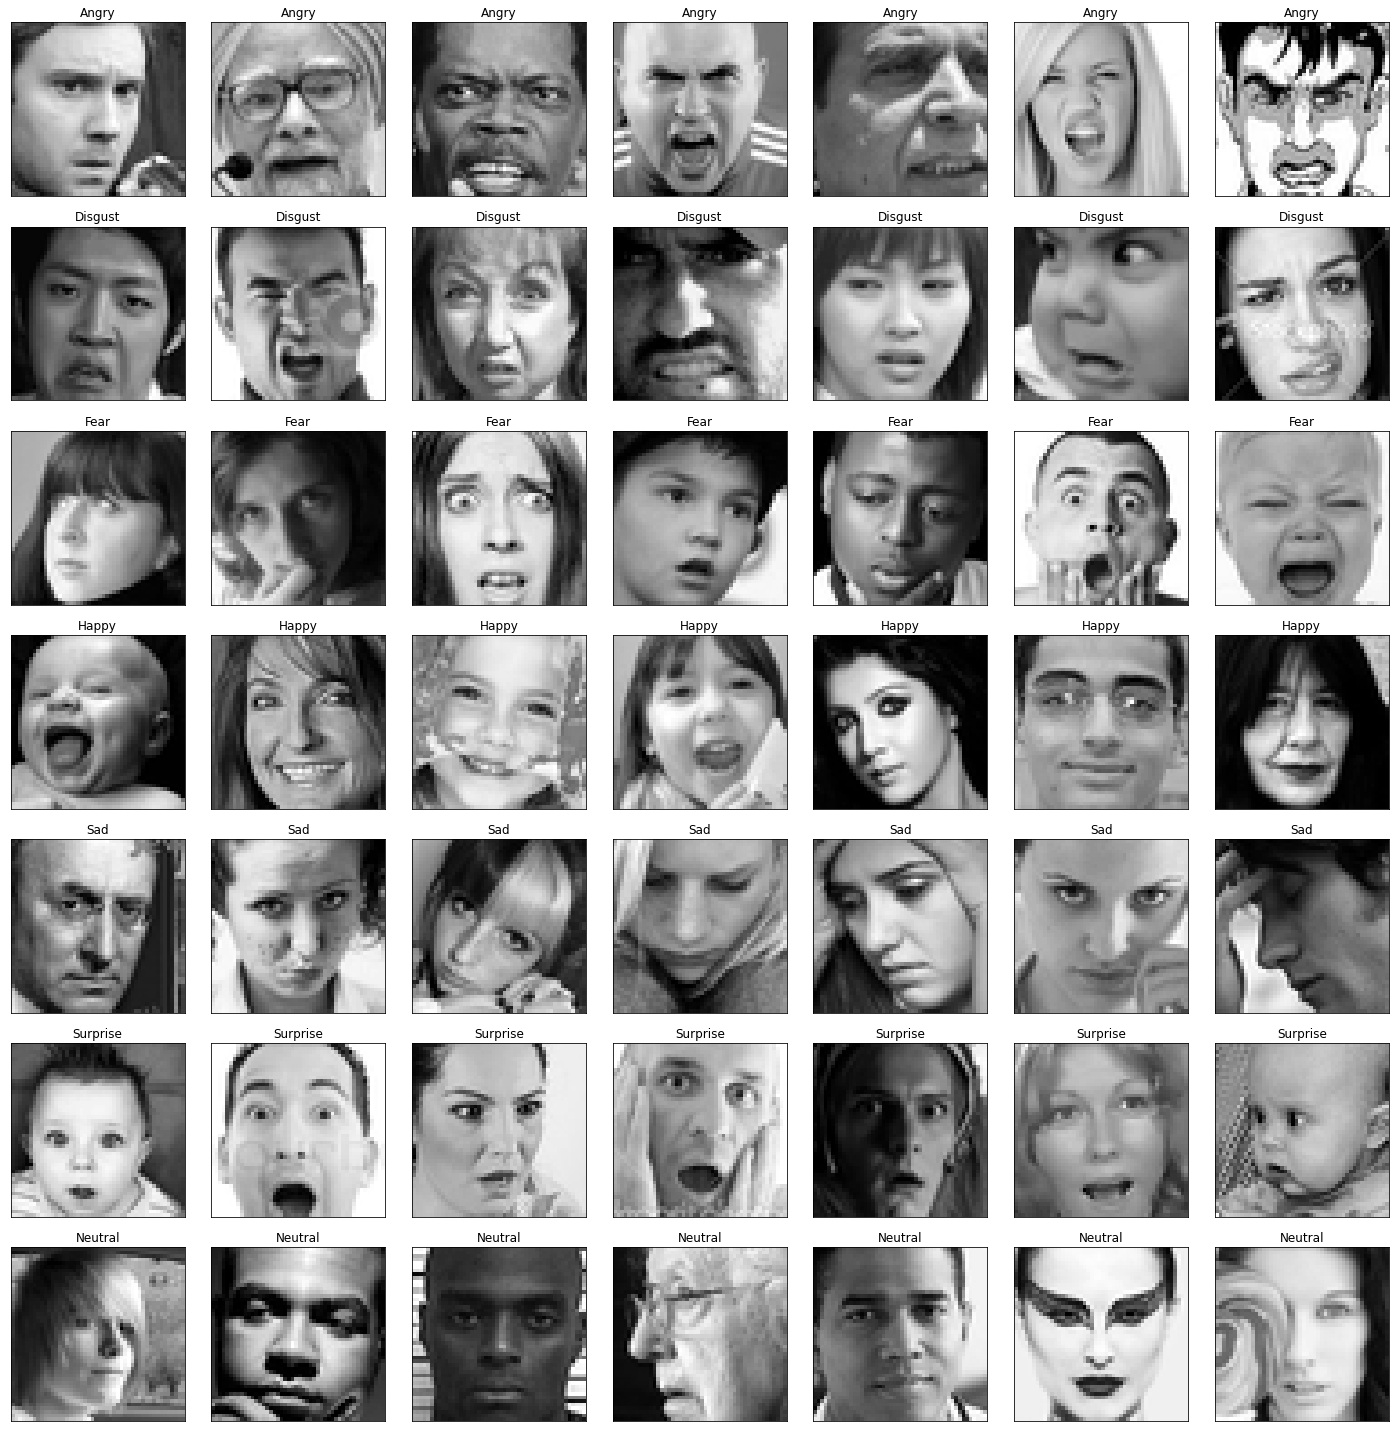

In [10]:
fig = plt.figure(1, (20, 20))

k = 0
for label in sorted(df['emotion'].unique()):
    for j in range(7):
        px = df[df['emotion']==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        plt.tight_layout()

In [11]:
train_data = df[df['Usage']=='Training']
train_data.drop(columns='Usage', inplace=True)
train_data.head()

C:\Users\Moon-yujin\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [12]:
train_data.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 672.9+ KB


In [14]:
train_data['pixels'][0]

'70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200 201 200 197 201 137 58 98 92

In [15]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

In [16]:
X_train, y_train = prepare_data(train_data)
print(X_train.shape, y_train.shape)

(28709, 48, 48, 1) (28709,)


In [17]:
X_train

array([[[[0.2745098 ],
         [0.31372549],
         [0.32156863],
         ...,
         [0.20392157],
         [0.16862745],
         [0.16078431]],

        [[0.25490196],
         [0.23921569],
         [0.22745098],
         ...,
         [0.21960784],
         [0.20392157],
         [0.17254902]],

        [[0.19607843],
         [0.16862745],
         [0.21176471],
         ...,
         [0.19215686],
         [0.21960784],
         [0.18431373]],

        ...,

        [[0.35686275],
         [0.25490196],
         [0.16470588],
         ...,
         [0.28235294],
         [0.21960784],
         [0.16862745]],

        [[0.30196078],
         [0.32156863],
         [0.30980392],
         ...,
         [0.41176471],
         [0.2745098 ],
         [0.18039216]],

        [[0.30196078],
         [0.28235294],
         [0.32941176],
         ...,
         [0.41568627],
         [0.42745098],
         [0.32156863]]],


       [[[0.59215686],
         [0.58823529],
         [0.57

In [18]:
y_train

array([0, 0, 2, ..., 4, 0, 4])

In [19]:
test_data = df[df['Usage']!='Training']
test_data.drop(columns='Usage', inplace=True)
test_data.head()

C:\Users\Moon-yujin\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,emotion,pixels
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [20]:
X_test, y_test = prepare_data(test_data)
print(X_test.shape, y_test.shape)

(7178, 48, 48, 1) (7178,)


In [21]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)

print('y_train', y_train.shape)
print('y_test', y_test.shape)

X_train (28709, 48, 48, 1)
X_test (7178, 48, 48, 1)
y_train (28709,)
y_test (7178,)


In [22]:
#train val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  shuffle=True, 
                                                  stratify=y_train,
                                                  test_size=0.2, 
                                                  random_state=121)

In [23]:
#encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = keras.utils.to_categorical(y_train)

In [24]:
#ecode labels
y_test = le.transform(y_test)
y_test = keras.utils.to_categorical(y_test)

In [25]:
#ecode labels
y_val = le.transform(y_val)
y_val = keras.utils.to_categorical(y_val)

In [26]:
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('y_val', y_val.shape)

y_train (22967, 7)
y_test (7178, 7)
y_val (5742, 7)


In [27]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [29]:
img_size = 48
batch_size = 32

#use Image Data Generator to perform this task
#train set
datagen = ImageDataGenerator(rotation_range=25, 
                             width_shift_range=0.1,
                             height_shift_range=0.1, 
                             shear_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True)

datagen.fit(X_train)
datagen.fit(X_val)

## Build Model

In [30]:
model = Sequential()

#1st conv
model.add(Conv2D(128, (3,3), padding='same', input_shape=(48,48,1))) #1 is for grayscale
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#2nd conv
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3rd conv
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th conv
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

In [31]:
#compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       4

In [33]:
from tensorflow.keras.utils import plot_model

#plot
plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [52]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
data = pd.read_csv('./data/icml_face_data.csv')

In [53]:
# 데이터 전처리 함수
def preprocessing(data):
    image = np.zeros(shape=(len(data), 48, 48))  # (48*48)
    label = np.array(list(map(int, data['emotion'])))
    
    for i,row in enumerate(data.index):
        df = np.fromstring(data[' pixels'][row], dtype=int, sep=' ')
        df = np.reshape(df, (48, 48))
        image[i] = df
    return image, label

In [54]:
# Train, Validation, Test 데이터 구분
x_train, y_train = preprocessing(data[data[' Usage'] == 'Training'])
x_val, y_val = preprocessing(data[data[' Usage'] == 'PrivateTest'])
x_test, y_test = preprocessing(data[data[' Usage']=='PublicTest'])

In [55]:
# shape 변경
print(x_train.shape, x_val.shape, x_test.shape)
x_train = x_train.reshape((x_train.shape[0], 48, 48, 1))
x_val = x_val.reshape((x_val.shape[0], 48, 48, 1))
x_test = x_test.reshape((x_test.shape[0], 48, 48, 1))
print(x_train.shape, x_val.shape, x_test.shape)

# 0 ~ 1 사이로 변경
x_train = x_train.astype('float32')/x_train.max()
x_val = x_val.astype('float32')/x_val.max()
x_test = x_test.astype('float32')/x_test.max()

(28709, 48, 48) (3589, 48, 48) (3589, 48, 48)
(28709, 48, 48, 1) (3589, 48, 48, 1) (3589, 48, 48, 1)


In [57]:
cnn = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])

# 모델 컴파일
cnn.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)

# 훈련(학습)
history = cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=64, callbacks=[early_stopping])

Epoch 1/30
449/449 [==============================] - 88s 194ms/step - loss: 1.6231 - accuracy: 0.3602 - val_loss: 1.4501 - val_accuracy: 0.4441
Epoch 2/30
449/449 [==============================] - 92s 204ms/step - loss: 1.4001 - accuracy: 0.4616 - val_loss: 1.3491 - val_accuracy: 0.4837
Epoch 3/30
449/449 [==============================] - 88s 195ms/step - loss: 1.2961 - accuracy: 0.5072 - val_loss: 1.3157 - val_accuracy: 0.4912
Epoch 4/30
449/449 [==============================] - 87s 193ms/step - loss: 1.2179 - accuracy: 0.5391 - val_loss: 1.2614 - val_accuracy: 0.5138
Epoch 5/30
449/449 [==============================] - 86s 193ms/step - loss: 1.1397 - accuracy: 0.5698 - val_loss: 1.2694 - val_accuracy: 0.5188
Epoch 6/30
449/449 [==============================] - 87s 193ms/step - loss: 1.0684 - accuracy: 0.6010 - val_loss: 1.2613 - val_accuracy: 0.5308
Epoch 7/30
449/449 [==============================] - 88s 195ms/step - loss: 0.9925 - accuracy: 0.6317 - val_loss: 1.2465 - val_ac

In [59]:
loss, acc = cnn.evaluate(x_test, y_test)
print('test정확도: ', acc)

113/113 [==============================] - 3s 28ms/step - loss: 1.7832 - accuracy: 0.5308
test정확도:  0.5307885408401489


## Train Model

In [34]:
epochs = 100

#checkpoint to save best weights
checkpoint = ModelCheckpoint('model_weights.h5',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             mode='max')

#reduce learning rate if plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.00001,
                              mode='min')

#stop training if accuracy does not improve
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='max')

#define callbacks
callbacks = [tfdocs.modeling.EpochDots(), 
             earlystop, 
             checkpoint, 
             reduce_lr]

In [ ]:
%%time

#(datagen.flow(X_train, y_train, batch_size=batch_size)
 
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    verbose=0)

## Evaluate Model

NameError: name 'history' is not defined

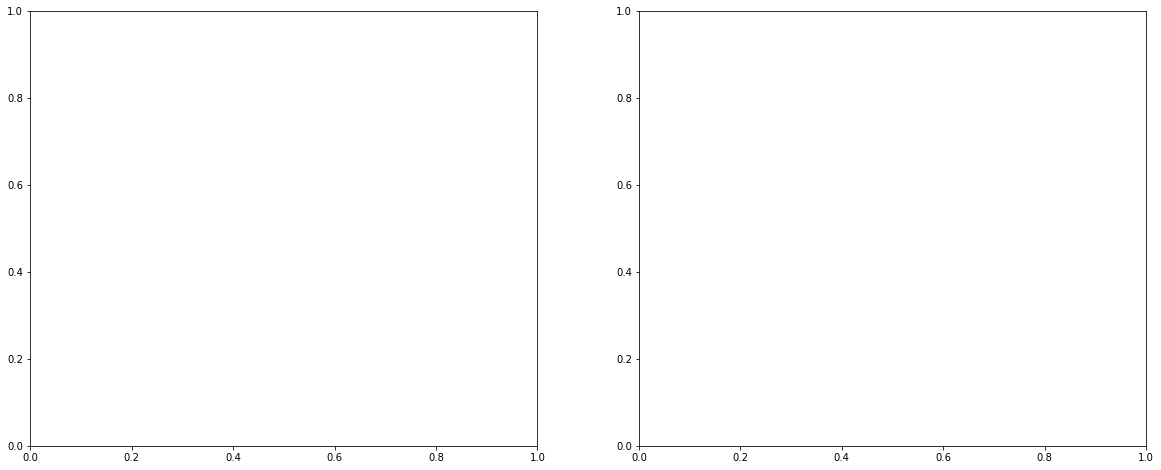

In [36]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [35]:
print('Train accuracy & loss:', model.evaluate(X_train, y_train))
print('\n')
print('Test accuracy & loss:', model.evaluate(X_test, y_test))

718/718 [==============================] - 203s 282ms/step - loss: 1.9409 - accuracy: 0.2468
Train accuracy & loss: [1.9409451484680176, 0.2467888742685318]


225/225 [==============================] - 58s 255ms/step - loss: 1.9410 - accuracy: 0.2412
Test accuracy & loss: [1.9410481452941895, 0.2411535233259201]


In [36]:
#make prediction
yhat_test = np.argmax(model.predict(X_test), axis=1)
yhat_test

array([3, 3, 3, ..., 3, 3, 3], dtype=int64)

In [37]:
y_test = np.argmax(y_test, axis=1)
y_test

array([0, 1, 4, ..., 0, 3, 2], dtype=int64)

[[   1    0    0  888    0    0   69]
 [   0    0    0  105    0    0    6]
 [   0    0    0  956    0    0   68]
 [   0    0    0 1640    0    0  134]
 [   0    0    0 1133    0    0  114]
 [   0    0    0  794    0    0   37]
 [   0    0    0 1143    0    0   90]]


C:\Users\MOON-Y~1\AppData\Local\Temp/ipykernel_21336/1756051866.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


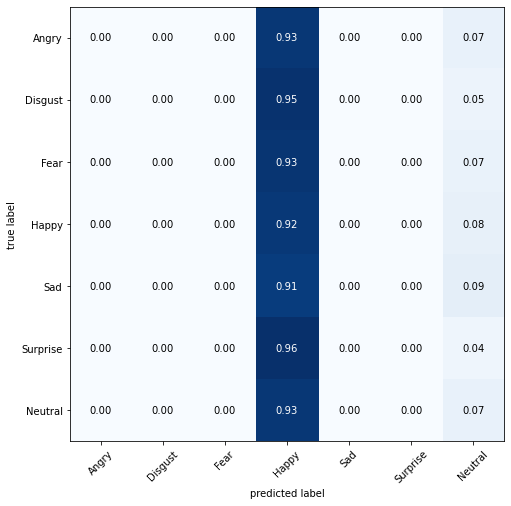

In [43]:
from mlxtend.plotting import plot_confusion_matrix

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

In [44]:
#get classification report
print(classification_report(y_test, yhat_test, target_names=emotions.values()))

              precision    recall  f1-score   support

       Angry       1.00      0.00      0.00       958
     Disgust       0.00      0.00      0.00       111
        Fear       0.00      0.00      0.00      1024
       Happy       0.25      0.92      0.39      1774
         Sad       0.00      0.00      0.00      1247
    Surprise       0.00      0.00      0.00       831
     Neutral       0.17      0.07      0.10      1233

    accuracy                           0.24      7178
   macro avg       0.20      0.14      0.07      7178
weighted avg       0.22      0.24      0.11      7178



C:\Users\Moon-yujin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Moon-yujin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Moon-yujin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
model_json = model.to_json()
with open('model.json','w') as json_file:
    json_file.write(model_json)
    
model.save('final_model.h5')

## Make Prediction

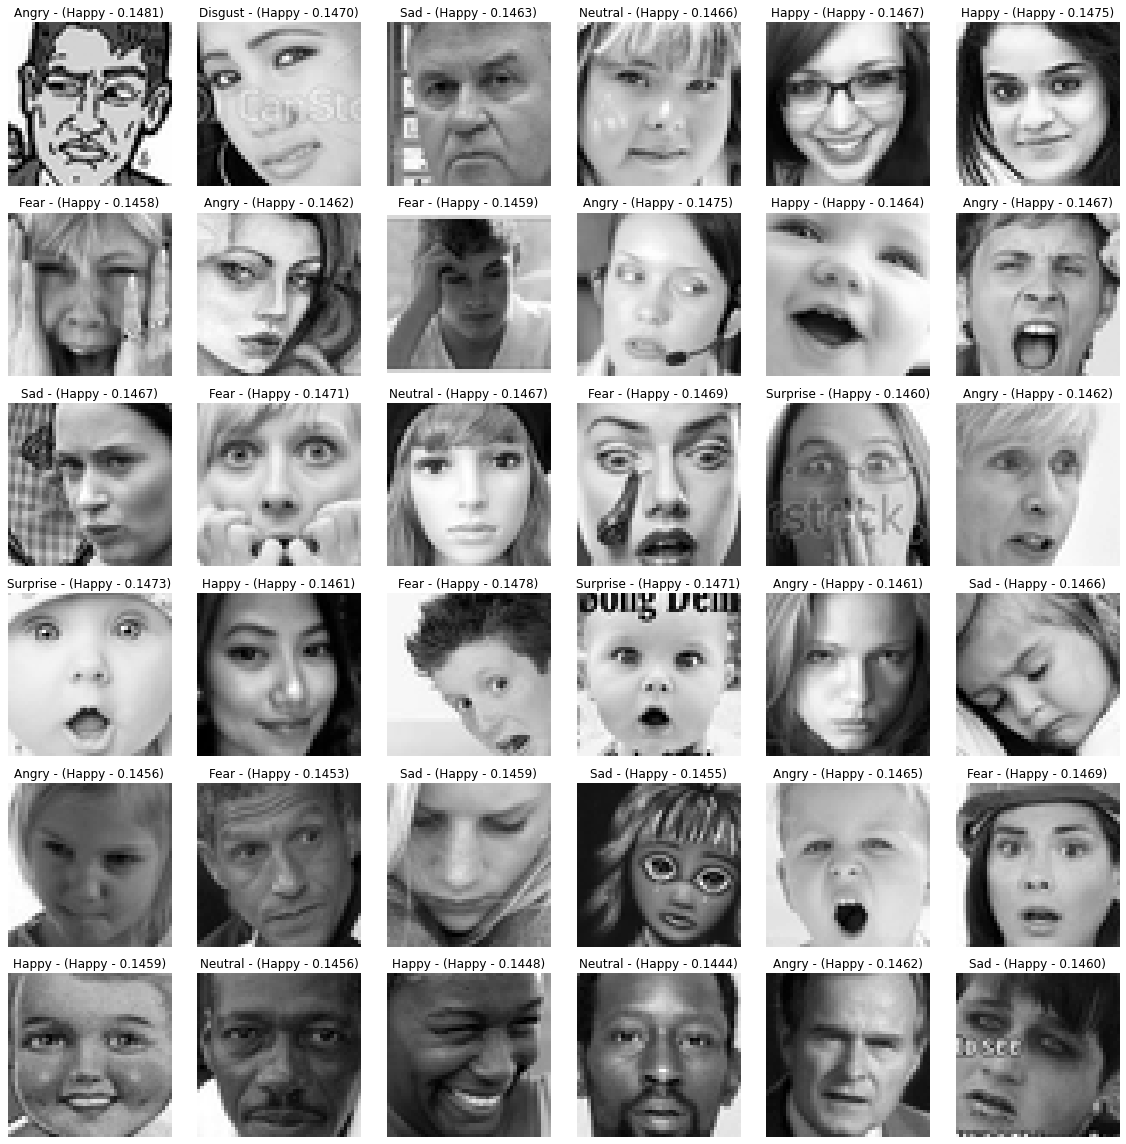

In [46]:
plt.figure(figsize=[16,16])

for i in range(36):
    img = X_test[i,:,:,0]
    p_dist = model.predict(img.reshape(1, 48, 48, 1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    plt.subplot(6, 6, i+1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'{emotions[y_test[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [47]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )
           
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

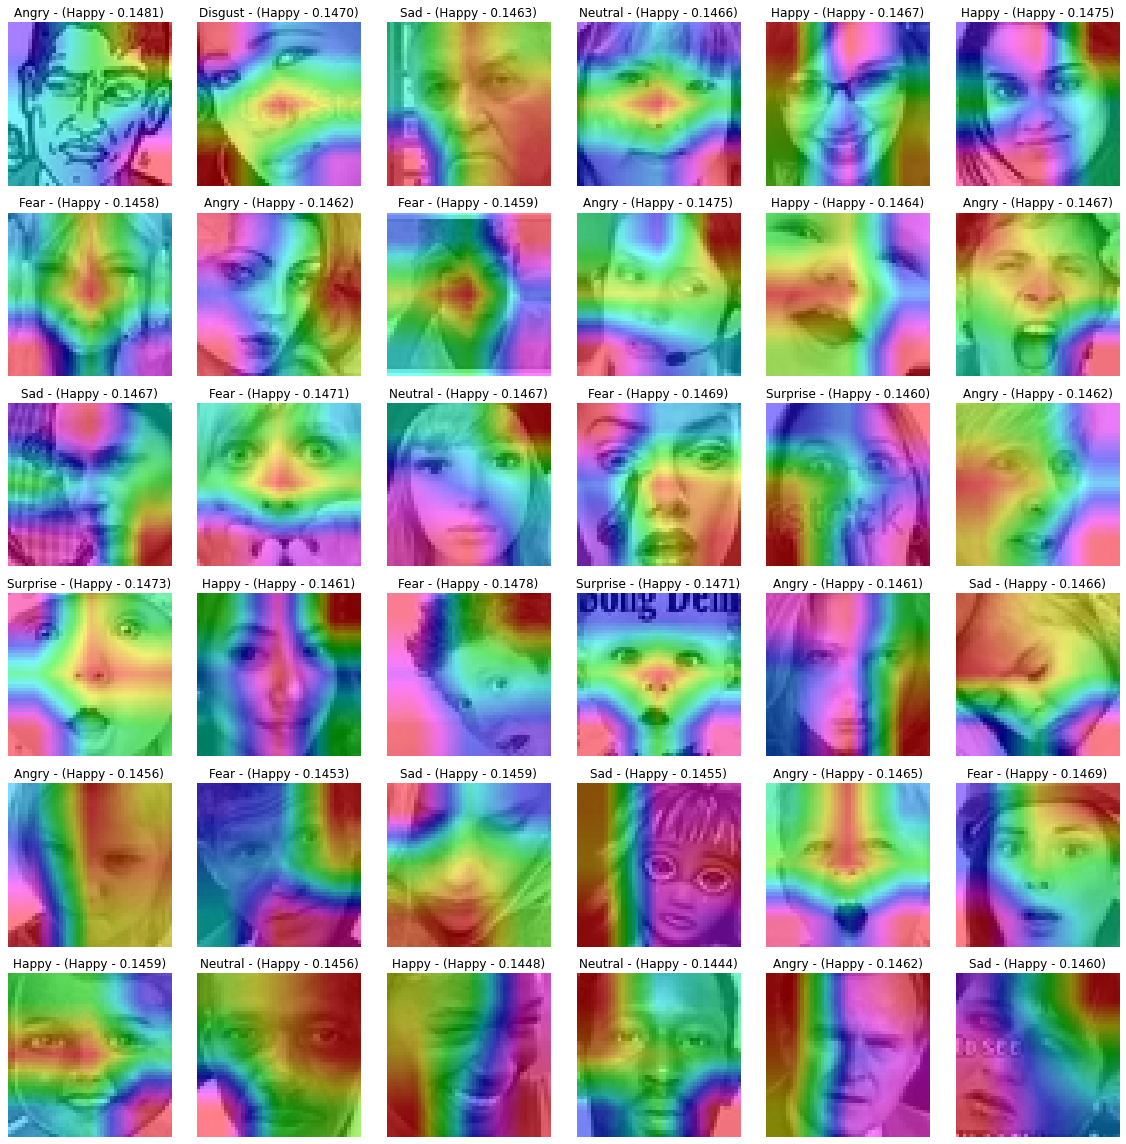

In [48]:
plt.figure(figsize=[16,16])
for i in range(36):
    img = X_test[i,:,:,0]
    p_dist = model.predict(img.reshape(1, 48, 48, 1))
    k = np.argmax(p_dist)
    p = np.max(p_dist)

    cam = GradCAM(model, k)
    heatmap = cam.compute_heatmap(img.reshape(1, 48, 48, 1))

    plt.subplot(6, 6, i+1)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='hsv')
    plt.title(f'{emotions[y_test[i]]} - ({emotions[k]} - {p:.4f})')
    plt.axis('off')
    
plt.tight_layout()
plt.show()

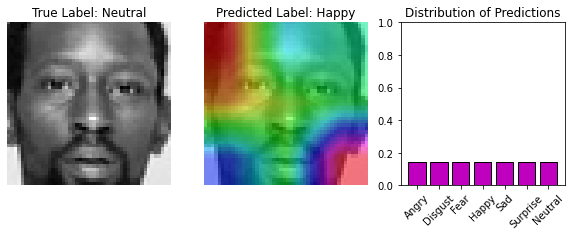

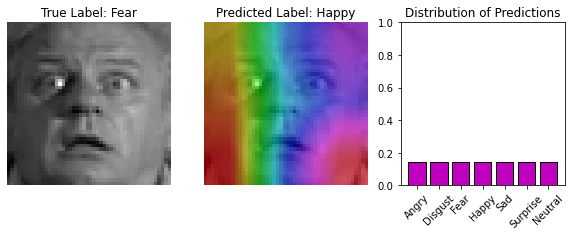

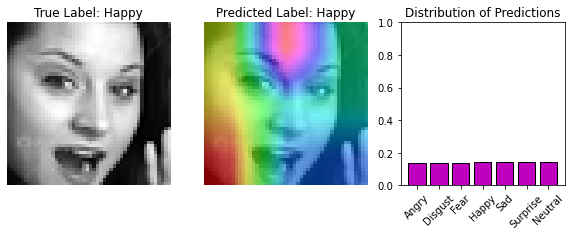

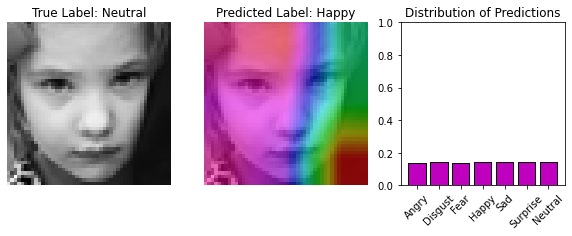

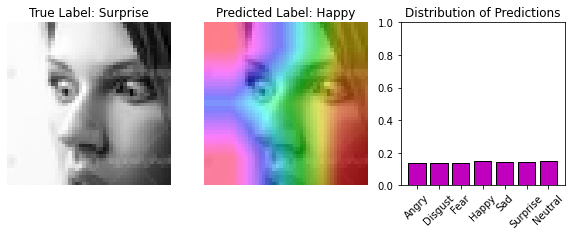

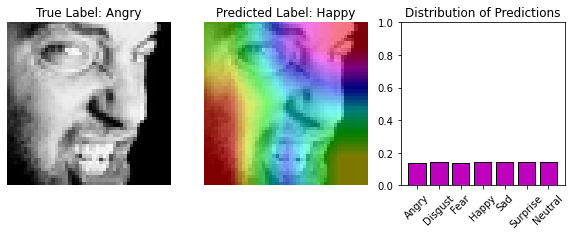

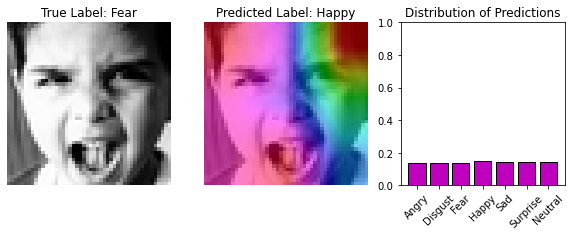

In [49]:
test_prob = model.predict(X_test)
test_pred = np.argmax(test_prob, axis=1)

sel_imgs = [33, 1000, 88, 777, 108, 111, 7000]

for n in sel_imgs:
    img = X_test[n,:,:,0]
    
    plt.figure(figsize=[10,3])
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='binary_r')
    plt.title(f'True Label: {emotions[y_test[n]]}')
    plt.axis('off')
    
    cam = GradCAM(model, test_pred[n])
    heatmap = cam.compute_heatmap(img.reshape(1,48,48,1))
    
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='binary_r')
    plt.imshow(heatmap, alpha=0.5, cmap='hsv')
    plt.title(f'Predicted Label: {emotions[test_pred[n]]}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.bar(emotions.values(), test_prob[n, :], color='m', edgecolor='k')
    plt.xticks(rotation=45)
    plt.ylim([0,1])
    plt.title('Distribution of Predictions')
    plt.show()